Author: Hem N Chaudhary

Date: Jan, 2024

Description: Fine tuning text classification model using two methods. 1) Feature Extraction Method, where hidden states are used as features and a classifier is trained on them. 2) Finetuning Method, where parameters throughout the models are tuned.

In [ ]:
#Checking the status of compute
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan 13 02:30:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
! pip install datasets

In [ ]:
from datasets import list_datasets

In [ ]:
all_datasets=list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

<ipython-input-4-2d3fdbc63bc4>:1: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets=list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


There are 94775 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [ ]:
from datasets import load_dataset
emotions=load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
#This is the dataset comprised of tweets
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds=emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
len(train_ds)

16000

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


From Datasets to DataFrames

In [ ]:
!pip install pandas
import pandas as pd

In [ ]:
emotions.set_format(type="pandas")
df=emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
#mapping numerical labels to actual class of emotions
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)
df["label_name"]=df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


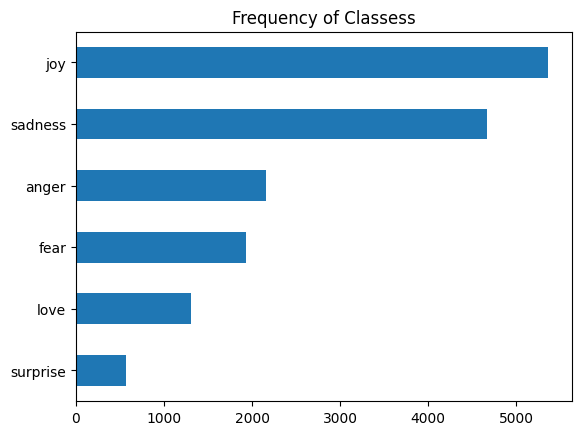

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classess")
plt.show()

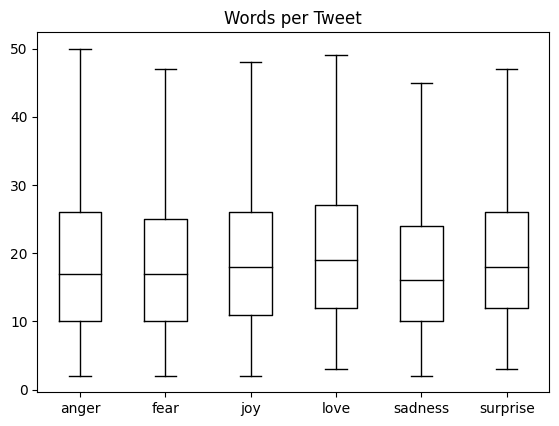

In [ ]:
df["Words per Tweet"]=df["text"].str.split().apply(len)
df.boxplot("Words per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [ ]:
emotions.reset_format()

**From Text to Tokens/ Tokenization**

In [ ]:
from transformers import AutoTokenizer

model_ckpt="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
text="Tokenizing text is a core task of NLP."
encoded_text=tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokens=tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.model_max_length

512

In [ ]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Tokenizing the Whole Dataset

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
emotions_encoded=emotions.map(tokenize, batched=True, batch_size=None)

In [ ]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


Transformers as Feature Extractors

In [ ]:
import torch

In [ ]:
from transformers import AutoModel

model_ckpt="distilbert-base-uncased"
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AutoModel.from_pretrained(model_ckpt).to(device)

Extracting the last hidden states

In [ ]:
text="this is a test"
inputs=tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [ ]:
print(inputs.items())
print(len(inputs.items()))

dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3231,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])
2


In [ ]:
inputs={k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs=model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [ ]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [ ]:
def extract_hidden_states(batch):
  #Place model inputs on the GPU
  inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state=model(**inputs).last_hidden_state
  #Return vectors for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
emotions_hidden=emotions_encoded.map(extract_hidden_states, batched=True)

In [ ]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [ ]:
import numpy as np

X_train=np.array(emotions_hidden["train"]["hidden_state"])
X_valid=np.array(emotions_hidden["validation"]["hidden_state"])
y_train=np.array(emotions_hidden["train"]["label"])
y_valid=np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

Visualizing the training set

In [ ]:
!pip install --upgrade umap-learn


In [ ]:
from umap.umap_ import UMAP
from sklearn.preprocessing import MinMaxScaler

#Scale features to [0,1] range
X_scaled=MinMaxScaler().fit_transform(X_train)

#Initialize and fit UMAP
mapper=UMAP(n_components=2, metric="cosine").fit(X_scaled)

#Create a DataFrame of 2D embeddings
df_emb=pd.DataFrame(mapper.embedding_, columns=["X","Y"])
df_emb["label"]=y_train
df_emb.head()

,X,Y,label
0,4.040988,7.010491,0
1,-3.270442,6.431754,0
2,5.071801,3.691862,3
3,-2.537429,4.471865,2
4,-3.605105,4.497290,3


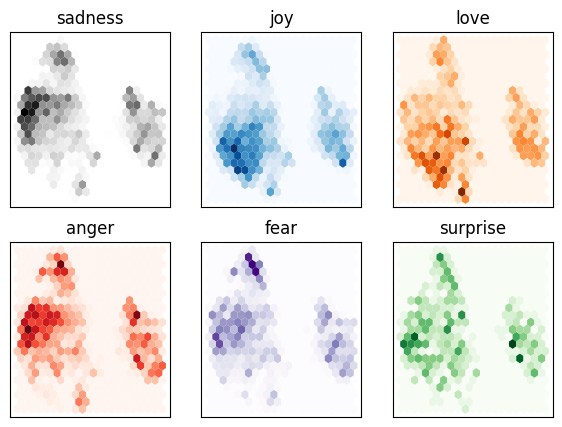

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names


for i, (label,cmap) in enumerate(zip(labels,cmaps)):
  df_emb_sub=df_emb.query(f"label=={i}")
  axes[i].hexbin(df_emb_sub["X"],df_emb_sub["Y"],cmap=cmap,gridsize=20,linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]),axes[i].set_yticks([])

#plt.tight_layouts()
plt.show()

Training a simple classifier

In [ ]:
from sklearn.linear_model import LogisticRegression

#We increase 'max_iter' to guarantee convergence
lr_clf=LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf=DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

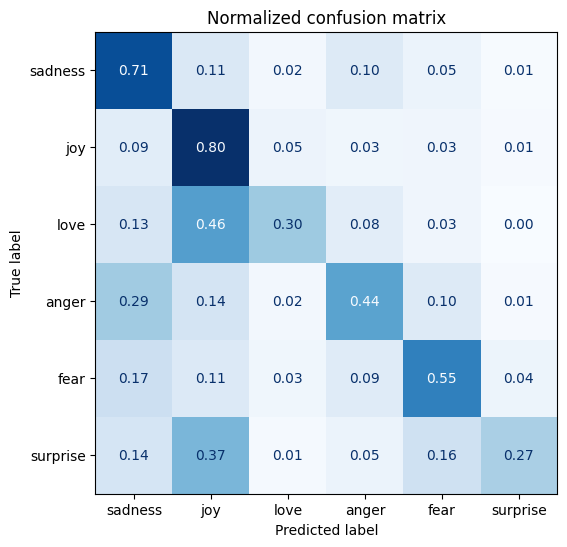

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm=confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds=lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds,y_valid, labels)

**Method 2**: FineTuning the Classification Models



In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip uninstall accelerate
!pip uninstall transformers
!pip install git+https://github.com/huggingface/accelerate
!pip install --upgrade transformers

Found existing installation: accelerate 0.26.1
Uninstalling accelerate-0.26.1:
  Would remove:
    /usr/local/bin/accelerate
    /usr/local/bin/accelerate-config
    /usr/local/bin/accelerate-estimate-memory
    /usr/local/bin/accelerate-launch
    /usr/local/lib/python3.10/dist-packages/accelerate-0.26.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/accelerate/*
Proceed (Y/n)? Y
  Successfully uninstalled accelerate-0.26.1
Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Would remove:
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.10/dist-packages/transformers-4.36.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/transformers/*
Proceed (Y/n)? Y
  Successfully uninstalled transformers-4.36.2
  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-f75rqkbk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-f75rqkbk
  Resolved https://g

  Using cached transformers-4.36.2-py3-none-any.whl (8.2 MB)


In [ ]:
import accelerate
import transformers

print("accelerate version:", accelerate.__version__)
print("transformers version:", transformers.__version__)

accelerate version: 0.27.0.dev0
transformers version: 4.36.2


In [ ]:
from transformers import Trainer, TrainingArguments
import accelerate
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [ ]:
from transformers import Trainer
trainer = Trainer(model=model, args=training_args,
                      compute_metrics=compute_metrics,
                      train_dataset=emotions_encoded["train"],
                      eval_dataset=emotions_encoded["validation"],
                      tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.803500,0.299135,0.914500,0.914295
2,0.241300,0.213848,0.923500,0.923657


In [ ]:
preds_output=trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.2138475924730301,
 'test_accuracy': 0.9235,
 'test_f1': 0.92365716261768,
 'test_runtime': 1.0776,
 'test_samples_per_second': 1856.023,
 'test_steps_per_second': 29.696}

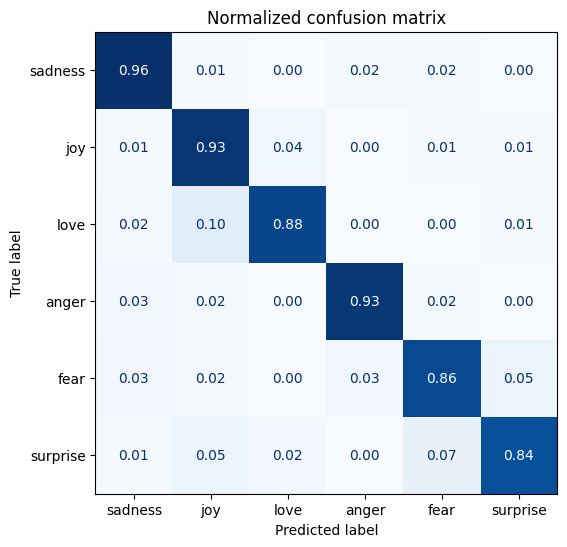

In [ ]:
y_preds=np.argmax(preds_output.predictions, axis=1)

plot_confusion_matrix(y_preds, y_valid, labels)

Error Analysis

In [ ]:
from torch.nn.functional import cross_entropy

In [ ]:
def forward_pass_with_label(batch):
  #place all input tensors on the same device as the model
  inputs={k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output=model(**inputs)
    pred_label=torch.argmax(output.logits, axis=-1)
    loss=cross_entropy(output.logits, batch["label"].to(device), reduction="none")

  #place outputs on CPU for compatibility with other datasets columns
  return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [ ]:
#convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

#Compute loss value
emotions_encoded["validation"]=emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols= ["text", "label", "predicted_label", "loss"]
df_test=emotions_encoded["validation"][:][cols]
df_test["label"]=df_test["label"].apply(label_int2str)
df_test["predicted_label"]=(df_test["predicted_label"].apply(label_int2str))

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.514533
1950,i as representative of everything thats wrong ...,surprise,sadness,5.502743
1801,i feel that he was being overshadowed by the s...,love,sadness,5.395996
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.998482
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.990252
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.949680
1963,i called myself pro life and voted for perry w...,joy,sadness,4.927140
1509,i guess this is a memoir so it feels like that...,joy,fear,4.585745
1274,i am going to several holiday parties and i ca...,joy,sadness,4.471143
1836,i got a very nasty electrical shock when i was...,fear,anger,4.320194


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
19,i had lunch with an old friend and it was nice...,joy,joy,0.016561
632,i feel he is an terrific really worth bet,joy,joy,0.016867
802,i hate hate hate watching people work and me s...,joy,joy,0.016936
669,i am not feeling very joyful today its been a ...,joy,joy,0.017129
1263,i feel this way about blake lively,joy,joy,0.017179
1873,i feel practically virtuous this month i have ...,joy,joy,0.017214
1421,i feel undeservingly lucky to be surrounded by...,joy,joy,0.017260
1511,i have to be overactive and stressed out to fe...,joy,joy,0.017280
1595,i am good at what i do at helping and reaching...,joy,joy,0.017431
1254,im fighting some sniffles that developed last ...,joy,joy,0.017472


Saving and Sharing Models

In [ ]:
trainer.push_to_hub(commit_message="Training completed!")

events.out.tfevents.1705113238.7259c46f8737.15957.0:   0%|          | 0.00/5.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/hndc/distilbert-base-uncased-finetuned-emotion/commit/6bf4fb890806a481aafb0aed9e7d1a79f0a16873', commit_message='Training completed!', commit_description='', oid='6bf4fb890806a481aafb0aed9e7d1a79f0a16873', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline

#Change transformersbook to your Hub username
model_id="hndc/distilbert-base-uncased-finetuned-emotion"
classifier=pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
custom_tweet="I saw a movie today and it was really good."
preds=classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


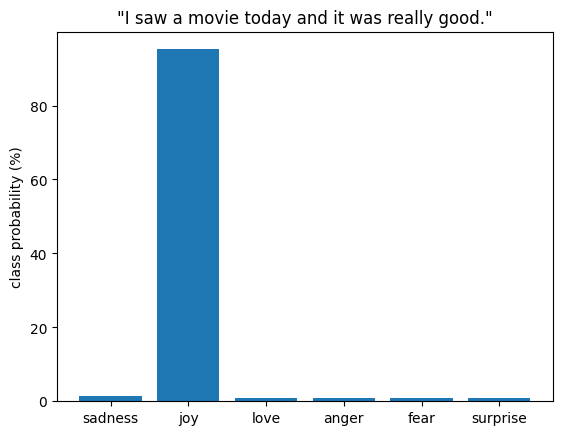

In [ ]:
preds_df=pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("class probability (%)")
plt.show()